In [ ]:
!./setup.sh

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from typing import Generator, Tuple

import torch
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2
from scripts.lib import read_dir, get_size
from scripts.augmentations import augmented

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data files into Datasets

In [21]:
TRAIN_PATH = "../data/real_vs_fake/real-vs-fake/train/"
TEST_PATH = "../data/real_vs_fake/real-vs-fake/test/"
VAL_PATH = "../data/real_vs_fake/real-vs-fake/valid/"

train_df = pl.DataFrame({
    'file': (fake_faces := os.listdir(TRAIN_PATH + '/fake')) + (real_faces := os.listdir(TRAIN_PATH + '/real')),
    'label': [ 'fake' for _ in range(len(fake_faces))] + ['real' for _ in range(len(real_faces)) ]
}).sample(fraction=1.)

val_df = pl.DataFrame({
    'file': (fake_faces := os.listdir(VAL_PATH + '/fake')) + (real_faces := os.listdir(VAL_PATH + '/real')),
    'label': [ 'fake' for _ in range(len(fake_faces))] + ['real' for _ in range(len(real_faces)) ]
})

test_df = pl.DataFrame({
    'file': (fake_faces := os.listdir(TEST_PATH + '/fake')) + (real_faces := os.listdir(TEST_PATH + '/real')),
    'label': [ 'fake' for _ in range(len(fake_faces))] + ['real' for _ in range(len(real_faces)) ]
})

file,label
str,str
"""32161.jpg""","""real"""
"""T9K5U1UF3Q.jpg…","""fake"""
"""93J7JY45EJ.jpg…","""fake"""
"""0IA4YMQHXE.jpg…","""fake"""
"""CN8PTADY1C.jpg…","""fake"""
"""13633.jpg""","""real"""
"""BAA871UQHB.jpg…","""fake"""
"""XZY26NVNP3.jpg…","""fake"""
"""PPSTVQEKQA.jpg…","""fake"""


In [2]:
fake_train_imgs = read_dir("../data/real_vs_fake/real-vs-fake/train/fake")
real_train_imgs = read_dir("../data/real_vs_fake/real-vs-fake/train/real")

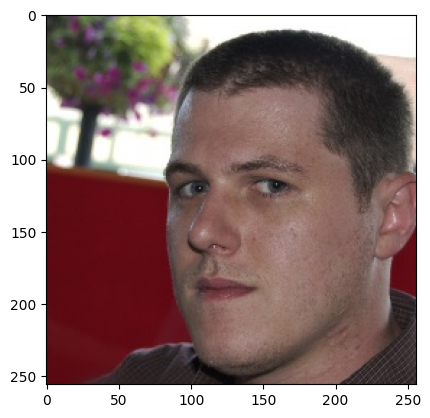

In [4]:
plt.imshow(img:=next(iter(real_train_imgs)))

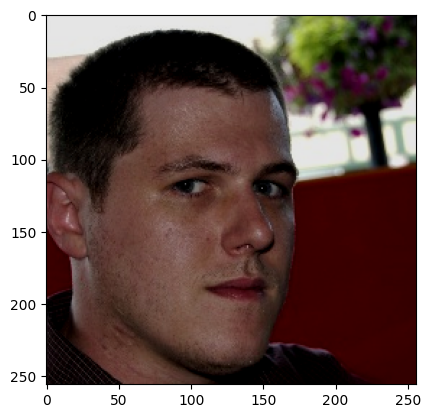

In [8]:
plt.imshow(augmented(img))

In [24]:
class FacesDataSet(Dataset):
    """
        fake: 0, real: 1
    """
    def __init__(self, data: Tuple[Generator, Generator], size: int) -> None:
        self.data = data
        self.size = size
        self.counter = 0

    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        if self.counter <= self.size // 2:
            self.counter += 1
            return (next(iter(self.data[0])), 0)
        else:
            self.counter += 1
            return (next(iter(self.data[1])), 1)

In [29]:
size = get_size('../data/real_vs_fake/real-vs-fake/train')
train_loader = DataLoader(FacesDataSet((fake_train_imgs, real_train_imgs), size), shuffle=True)

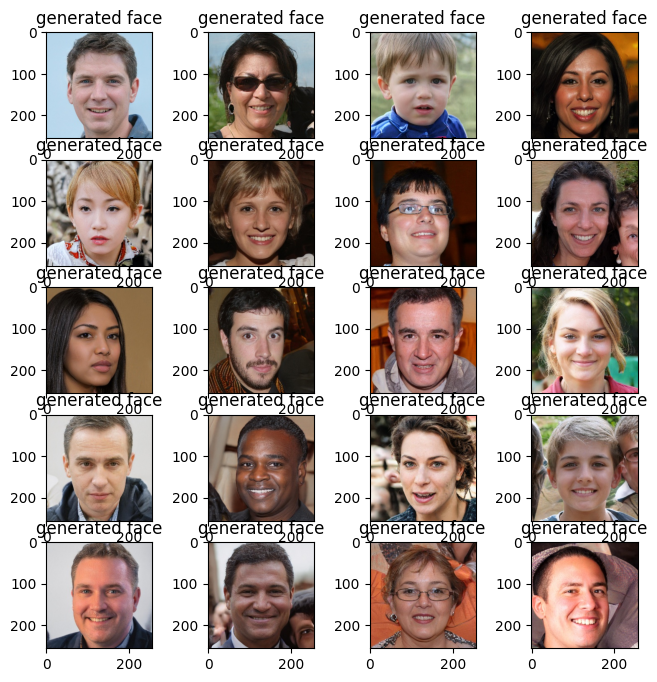

In [38]:
w, h = 10, 10
fig = plt.figure(figsize=(8, 8))
columns, rows = 4, 5

for i in range(1, columns * rows + 1):
    face, label = next(iter(train_loader))
    fig.add_subplot(rows, columns, i)
    plt.title("generated face" if label == 0 else "real face")
    plt.imshow(face.squeeze())

plt.show()

torch.Tensor